# L'analisi di regressione

In [1]:
source("_common.R")
library("rio")
library("car")
library("knitr")
library("markdown")
library("lavaan")
library("semPlot")

Loading required package: carData




Attaching package: ‘car’




The following object is masked from ‘package:dplyr’:

    recode




The following object is masked from ‘package:purrr’:

    some




This is lavaan 0.6-15
lavaan is FREE software! Please report any bugs.



La conoscenza dell'analisi di regressione è necessaria per capire la teoria classica dei test, l'analisi fattoriale e i modelli di equazioni strutturali. Sebbene le tecniche dell'analisi di regressione analizzino solo le variabili osservate, i principi  della regressione costituiscono la base delle tecniche più avanzate che includono anche le variabili latenti.

## Regressione bivariata

Il modello di regressione bivariata descrive l'associazione tra il valore atteso di $Y \mid x_i$ e $x$ nei termini di una relazione lineare:

$$
\mathbb{E}(Y \mid x_i) = \alpha + \beta x_i,
$$
dove i valori $x_i$ sono considerati fissi per disegno. Nel modello "classico", si assume che le distribuzioni $Y \mid x_i$ siano Normali con deviazione standard $\sigma_\varepsilon$. 

Il significato dei coefficienti di regressione è semplice:

- $\alpha$ è il valore atteso di $Y$ quando $X = 0$;
- $\beta$ è l'incremento atteso nel valore atteso di $Y$ quando $X$ aumenta di un'unità.

Il modello statistico della regressione bivariata è rappresentato nella figura seguente.

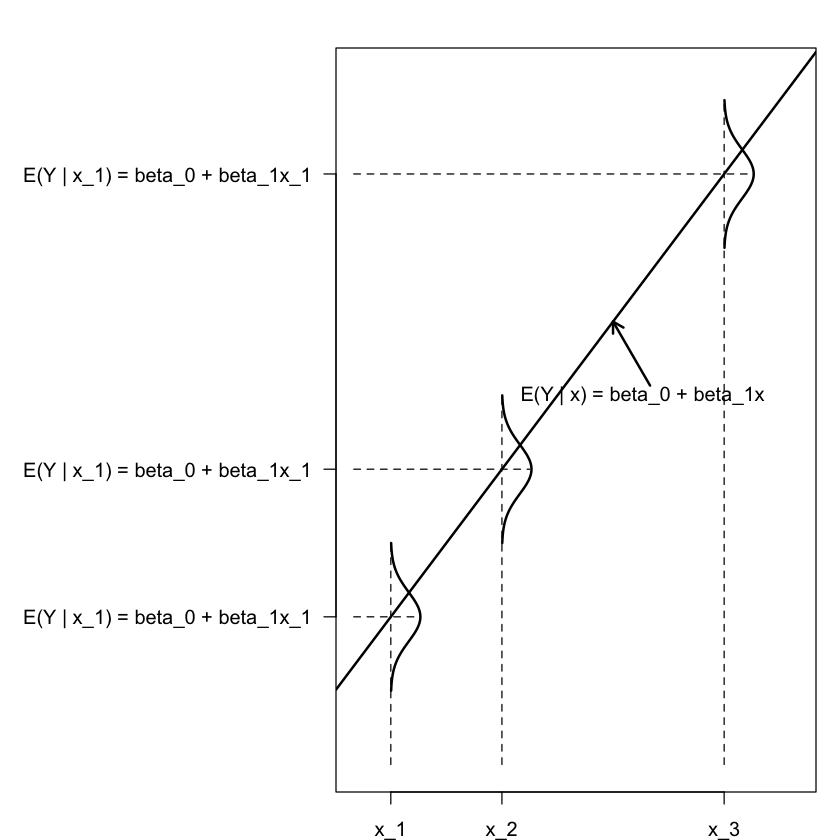

In [2]:
opar <- par(no.readonly = TRUE) # copy of current settings
par(mar = c(2, 14, 2, 1), las = 1)

DF <- data.frame(x = c(1, 4, 9), y = c(1, 4, 9))

plot(y~x, data = DF, xaxt = "n", yaxt = "n", 
     xlim = c(0, 12), ylim = c(-2, 12),
     xlab = "", ylab = "", type = "n")
abline(lm(y~x, data = DF), lwd = 2)
axis(side =1, at =c(1, 4, 10), 
     labels = c("x_1", "x_2", "x_3"))
axis(side =2, at =c(1, 4, 10),
     labels = c("E(Y | x_1) = beta_0 + beta_1x_1",
                "E(Y | x_1) = beta_0 + beta_1x_1",
                "E(Y | x_1) = beta_0 + beta_1x_1") )
segments(1, -2, 1, 2.5, lty = "dashed")
segments(0, 1, 1 + 0.75, 1, lty = "dashed")
segments(4, -2, 4, 5.5, lty = "dashed")
segments(0, 4, 4 + 0.75, 4, lty = "dashed")
segments(10, -2, 10, 11.5, lty = "dashed")
segments(0, 10, 10 + 0.75, 10, lty = "dashed")
ys <- seq(-1.5, 1.5, length = 200)
xs <- dnorm(ys, 0, 0.5)
lines(xs + 1, ys + 1, type = "l",lwd = 2)
lines(xs + 4, ys + 4, type = "l",lwd = 2)
lines(xs + 10, ys + 10, type = "l",lwd = 2)
text(7.8, 5.5, "E(Y | x) = beta_0 + beta_1x")
arrows(8, 5.7, 7, 7, length = 0.1, lwd = 2)
par(opar)

Per fare un esempio pratico, consideriamo i dati dell'antropologo Sahlins, il quale si è chiesto se esiste un'associazione tra l'ampiezza del clan (`consumers`) e l'area occupata da quel clan (`acres`) in una popolazione di cacciatori-raccoglitori. I dati sono i seguenti:

In [3]:
data(Sahlins)
head(Sahlins) 

,consumers,acres
,<dbl>,<dbl>
1,1.00,1.71
2,1.08,1.52
3,1.15,1.29
4,1.15,3.09
5,1.20,2.21
6,1.30,2.26


`geom_smooth()` using formula = 'y ~ x'


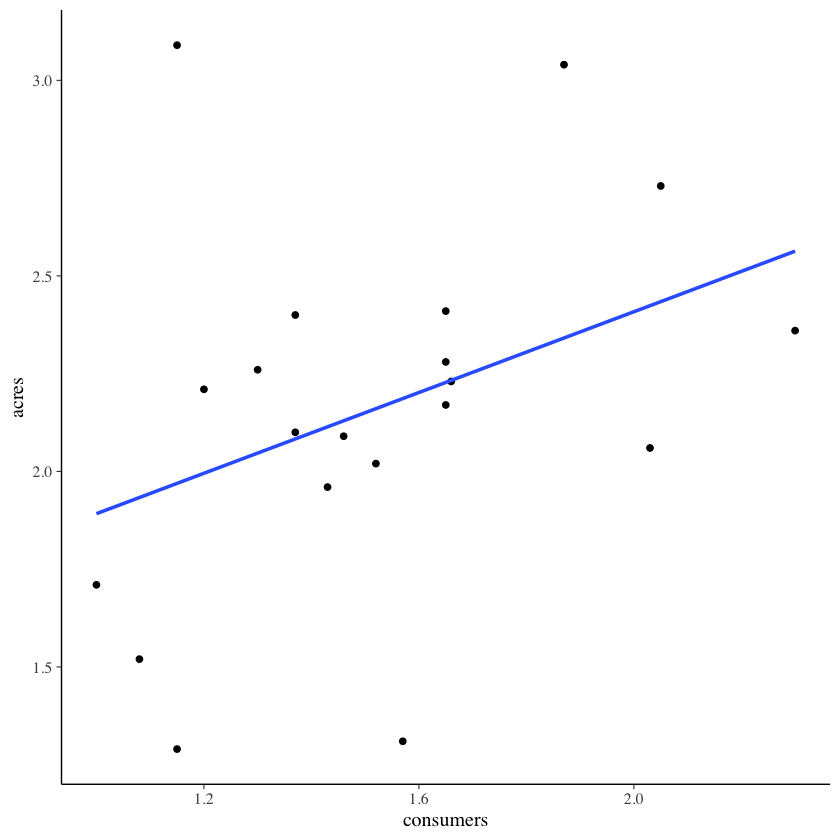

In [4]:
Sahlins %>% 
  ggplot(aes(x = consumers, y = acres)) +
  geom_point() +
  geom_smooth(method=lm, se=FALSE)

In [5]:
fm <- lm(acres ~ consumers, data = Sahlins)
fm$coef

(Intercept)   consumers 
  1.3756445   0.5163201

Dalla figura notiamo che, se `consumers` aumenta di un'unità (da 1.2 a 2.2), allora la retta di regressione (ovvero, il valore atteso di $Y$) aumenta di circa 0.5 punti -- esattamente, aumenta di 0.5163 punti, come indicato dalla stima del coefficiente $\beta$. L'interpretazione del coefficiente $\alpha$ è più problematica, perché non ha senso pensare ad un clan di ampiezza 0. Per affrontare questo problema, centriamo il predittore.

### Regressori centrati

Esprimiamo la variabile `consumers` nei termini degli scarti dalla media:

In [6]:
Sahlins <- Sahlins %>% 
  mutate(
    xc = consumers - mean(consumers)
  )

Svolgiamo nuovamente l'analisi di regressione con il nuovo predittore:

In [7]:
fm1 <- lm(acres ~ xc, data = Sahlins)
fm1$coef

(Intercept)          xc 
  2.1620000   0.5163201

`geom_smooth()` using formula = 'y ~ x'


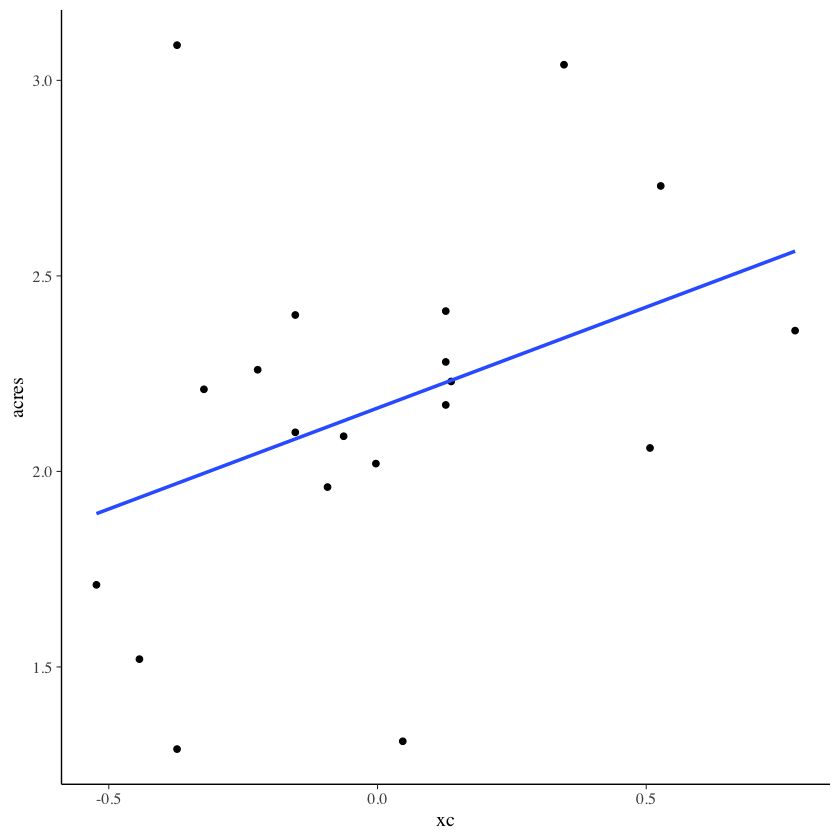

In [8]:
Sahlins %>% 
  ggplot(aes(x = xc, y = acres)) +
  geom_point() +
  geom_smooth(method=lm, se=FALSE)

La stima di $\beta$ è rimasta invariata ma ora possiamo attribuire un significato alla stima di $\alpha$: questo coefficiente indica il valore atteso della $Y$ quando $X$ assume il suo valore medio.

### Minimi quadrati

La stima dei coefficienti del modello di regressione può essere effettuata in modi diversi: massima verosimiglianza o metodi bayesiani. Se ci limitiamo qui alla massima verosimiglianza possiamo semplificare il problema assumento che le distribuzioni condizionate $Y \mid x$ siano Normali. In tali circostanze, la stima dei coefficienti del modello di regressione può essere trovata con il metodo dei minimi quadrati.

In pratica, questo significa trovare i coefficienti $a$ e $b$ che minimizzano 

$$
SS_{\text{res}} = \sum(y_i - \hat{y}_i)^2,
$$
con $\hat{y}_i = a + b x_i$.

Per fornire un'idea di come questo viene fatto, usiamo una simulazione. Per semplicità, supponiamo di conoscere $a = 1.3756445$ e di volere stimare $b$.

In [9]:
x <- Sahlins$consumers
y <- Sahlins$acres
a <- 1.3756445

nrep <- 1e3
b <- seq(0, 1, length.out = nrep)

ssres <- rep(NA, nrep)
for (i in 1:nrep) {
  yhat <- a + b[i] * x
  ssres[i] <- sum((y - yhat)^2)
}

Un grafico di $SS_{\text{res}}$ in funzione di $b$ mostra che il valore $b$ che minimizza $SS_{\text{res}}$ corrisponde, appunto, a 0.5163.

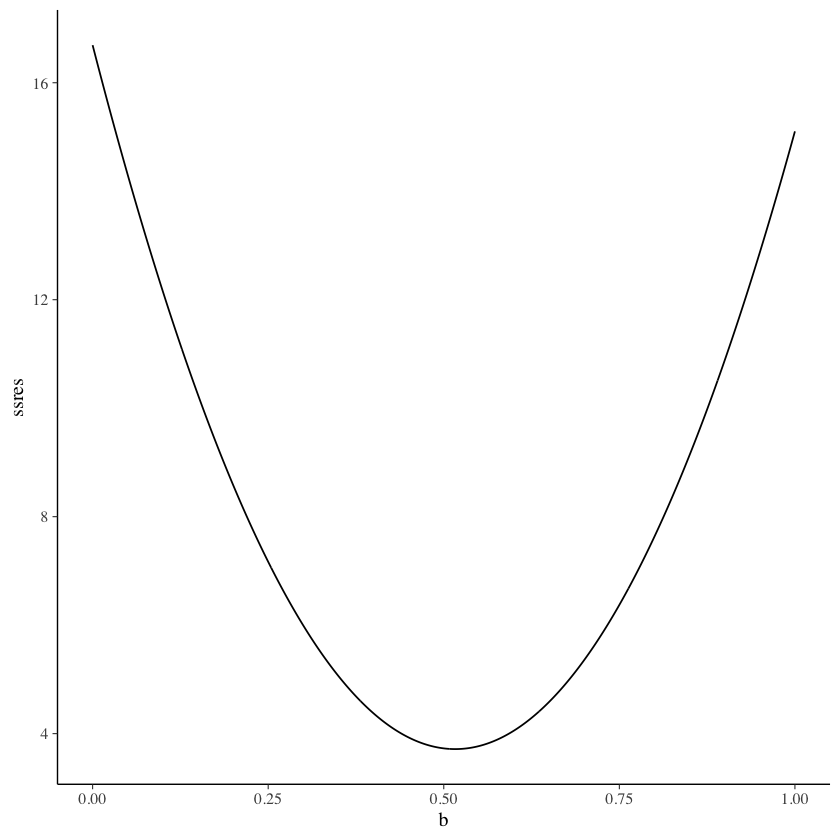

In [10]:
tibble(b, ssres) %>% 
  ggplot(aes(x = b, y = ssres)) +
  geom_line() 

### Relazione tra $b$ e $r$

Un altro modo per interpretare $b$ è quello di considerare la relazione tra la pendenza della retta di regressione e il coefficiente di correlazione:

$$
b_X = r_{XY} \frac{S_X}{S_Y}
$$

L'equazione precedente rende chiaro che, se i dati sono standardizzati, $b = r$.

Verifichiamo:

In [11]:
Sahlins %>% 
  dplyr::select(acres, consumers) %>% 
  cor()

,acres,consumers
acres,1.0000000,0.3756561
consumers,0.3756561,1.0000000


In [12]:
fm2 <- lm(scale(acres) ~ scale(consumers), data = Sahlins)
fm2$coef

(Intercept) scale(consumers) 
    9.917106e-17     3.756561e-01

### Attenuazione

Il fenomeno dell'attenuazione si verifica quando $X$ viene misurato con una componente di errore. Esaminiamo la seguente simulazione.

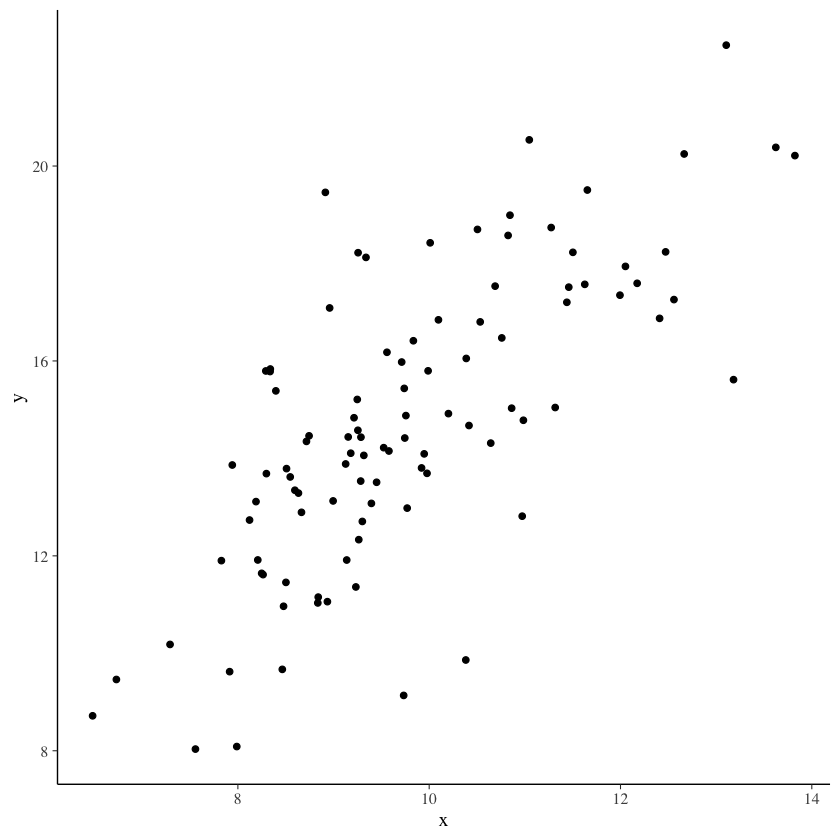

In [13]:
set.seed(1234)
n <- 100
x <- rnorm(n, 10, 1.5)
y <- 1.5 * x + rnorm(n, 0, 2)
tibble(x, y) %>% 
  ggplot(aes(x, y)) +
  geom_point()

In [14]:
sim_dat <- tibble(x, y)
fm <- lm(y ~ x, sim_dat)
fm$coef

(Intercept)           x 
  0.4221074   1.4652201

Questi sono i coefficienti di regressione quando $X$ è misurata senza errori.

In [15]:
sim_dat <- sim_dat %>% 
  mutate(
    x1 = x + rnorm(n, 0, 2)
  )

fm1 <- lm(y ~ x1, sim_dat)
fm1$coef

(Intercept)          x1 
  8.3872176   0.6295924

Aggiungendo una componente d'errore su $X$, la grandezza del coefficiente $b$ diminuisce.

### Coefficiente di determinazione

Tecnicamente, il coefficiente di determinazione è dato da:

$$
R^2 = \frac{\sum(\hat{y} - \bar{y})^2}{\sum(y_i - \bar{y})^2}
$$

Al denominatore abbiamo la _devianza totale_, ovvero una misura della dispersione di $y_i$ rispetto alla media $\bar{y}$. Al numeratore abbiamo una misura della dispersione del valore atteso della $Y$ rispetto alla sua media. Il rapporto, dunque, ci dice qual è la quota della variabilità totale di $Y$ che può essere predetta in base al modello lineare.

Per i dati di Sahlins abbiamo:

In [16]:
mod <- lm(acres ~ consumers, data = Sahlins)
a <- mod$coef[1]
b <- mod$coef[2]
yhat <- a + b * Sahlins$consumers
ss_tot <- sum((Sahlins$acres - mean(Sahlins$acres))^2)
ss_reg <- sum((yhat - mean(Sahlins$acres))^2)
r2 <- ss_reg / ss_tot
r2

[1] 0.1411175

Verifichiamo:

In [17]:
summary(mod)


Call:
lm(formula = acres ~ consumers, data = Sahlins)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8763 -0.1873 -0.0211  0.2135  1.1206 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   1.3756     0.4684   2.937  0.00881 **
consumers     0.5163     0.3002   1.720  0.10263   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4543 on 18 degrees of freedom
Multiple R-squared:  0.1411,	Adjusted R-squared:  0.0934 
F-statistic: 2.957 on 1 and 18 DF,  p-value: 0.1026


Da cui deriva che $R^2$ è uguale al quadrato del coefficiente di correlazione:

In [18]:
cor(Sahlins$acres, Sahlins$consumers)^2

[1] 0.1411175

### Errore standard della regressione

L'errore standard della regressione è una stima della dispersione di $y \mid x_i$ nella popolazione.  Non è altro che la deviazione standard dei residui

$$
e = y_i - \hat{y}_i
$$

che, al denominatore, riporta $n-2$. La ragione è che, per calcolare $\hat{y}$, vengono "perduti" due gradi di libertà -- il calcolo di $\hat{y}$ è basato sulla stima di due coefficienti: $a$ e $b$.

In [19]:
e <- yhat - Sahlins$acres
(sum(e^2) / (length(Sahlins$acres) - 2)) %>% 
  sqrt()

[1] 0.4543179

Il valore trovato corrisponde a quello riportato nell'output di `lm()`. 

## Regressione multipla

Nella regressione multipla vengono utilizzati $k > 1$ predittori:

$$
y_i = \alpha + \sum_{j=1}^k \beta_j x_i + \varepsilon_i.
$$

L'interpretazione geometrica è simile a quella del modello bivariato. Nel caso di due predittori, il valore atteso della $y$ può essere rappresentato da un piano; nel caso di $k > 2$ predittori, da un iper-piano. Nel caso di $k=2$, tale piano è posto in uno spazio di dimensioni $x_1$, $x_2$ (che possiamo immaginare definire un piano orizzontale) e $y$ (ortogonale a tale piano). La superficie piana che rappresenta $\mathbb{E}(y)$ è inclinata in maniera tale che l'angolo tra il piano e l'asse $x_1$ corrisponde a $\beta_1$ e l'angolo tra il piano e l'asse $x_2$ corrisponde a $\beta_2$.

### Significato dei coefficienti parziali di regressione

Ai coefficienti parziali del modello di regressione multipla possiamo assegnare la seguente interpretazione:

_Il coefficiente parziale di regressione $\beta_j$ rappresenta l'incremento atteso della $y$ se $x_j$ viene incrementata di un'unità, tenendo costante il valore delle altre variabili indipendenti._

Un modo per interpretare la locuzione "al netto dell'effetto delle altre variabili indipendenti" è quello di esaminare la relazione tra la $y$ parzializzata e la $x_j$ parzializzata. In questo contesto, parzializzare significa decomporre una variabile di due componenti: una componente che è linearmente predicibile da una o più altre variabili e una componente che è linearmente incorrelata con tali varibili "terze".

Se eseguiamo questa "depurazione" dell'effetto delle variabili "terze" sia sulla $y$ sia su $x_j$, possiamo poi esaminare la relazione bivariata che intercorre tra la componente della $y$ linearmente indipendente dalle variabili "terze" e la componente della $x_j$ linearmente indipendente dalle variabili "terze". Il coefficiente di regressione bivariato così ottenuto sarà identico al coefficiente parziale di regressione nel modello di regressione multipla. Questa procedura ci consente di assegnare un'interpretazione "intuitiva" al coefficiente parziale di regressione $\beta_j$.

Esaminiamo un caso concreto.

In [20]:
d <- rio::import("data/kidiq.dta")
glimpse(d)

Rows: 434
Columns: 5
$ kid_score <dbl> 65, 98, 85, 83, 115, 98, 69, 106, 102, 95, 91, 58, 84, 78, 1…
$ mom_hs    <dbl> 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, …
$ mom_iq    <dbl> 121.11753, 89.36188, 115.44316, 99.44964, 92.74571, 107.9018…
$ mom_work  <dbl> 4, 4, 4, 3, 4, 1, 4, 3, 1, 1, 1, 4, 4, 4, 2, 1, 3, 3, 4, 3, …
$ mom_age   <dbl> 27, 25, 27, 25, 27, 18, 20, 23, 24, 19, 23, 24, 27, 26, 24, …


In [21]:
fm <- lm(
  kid_score ~ mom_iq + mom_work + mom_age + mom_hs, data = d
)
fm$coef

(Intercept)      mom_iq    mom_work     mom_age      mom_hs 
 20.8226117   0.5620814   0.1337287   0.2198599   5.5611781

Eseguiamo la parzializzazione di $y$ in funzione delle variabili `mom_work`, `mom_age` e `mom_hs`:

In [22]:
fm_y <- lm(kid_score ~ mom_work + mom_age + mom_hs, data = d)

Lo stesso per `mom_iq`:

In [23]:
fm_x <- lm(mom_iq ~ mom_work + mom_age + mom_hs, data = d)

Esaminiamo ora la regressione bivariata tra le componenti parzializzate della $y$ e di $x_j$:

In [24]:
mod <- lm(fm_y$residuals ~ fm_x$residuals)
mod$coef

(Intercept) fm_x$residuals 
 -1.651851e-15   5.620814e-01

Si vede come il coefficiente di regressione bivariato risulta identico al corrispondente coefficiente parziale di regressione.

### Relazioni causali

Un altro modo per interpretare i coefficienti parziali di regressione è nell'ambito dei quelli che vengono chiamati i _path diagrams_. I diagrammi di percorso, che tratteremo in seguito e qui solo anticipiamo, descrivono le relazioni "causali" tra variabili: le variabili a monte del diagramma di percorso rappresentano le "cause" esogene e le variabili a valle indicano gli effetti, ovvero le variabili endogene. I coefficienti di percorso vengono rappresentati graficamente come frecce orientate e corrispondono all'effetto _diretto_ sulla variabile verso cui punta la freccia della variabile a monte della freccia. In tale rappresentazione grafica, i coefficienti di percorso non sono altro che i coefficienti parziali di regressione del modello di regressione multipla. In questo contesto, indicano l'effetto _diretto_ atteso sulla variabile endogena in conseguenza dell'incremento di un'unità della variabile esogena, *lasciano immutate tutte le altre relazioni strutturali* del modello.

Usiamo la funzione `sem()` del pacchetto `lavaan` per definire il modello rappresentato nel successivo diagramma di percorso:

In [25]:
model <- "
  kid_score ~ mom_hs + mom_iq + mom_work + mom_age
"

Adattiamo il modello ai dati

In [26]:
fit <- sem(model, data = d)

Il diagramma di percorso si ottiene con le seguenti istruzioni:

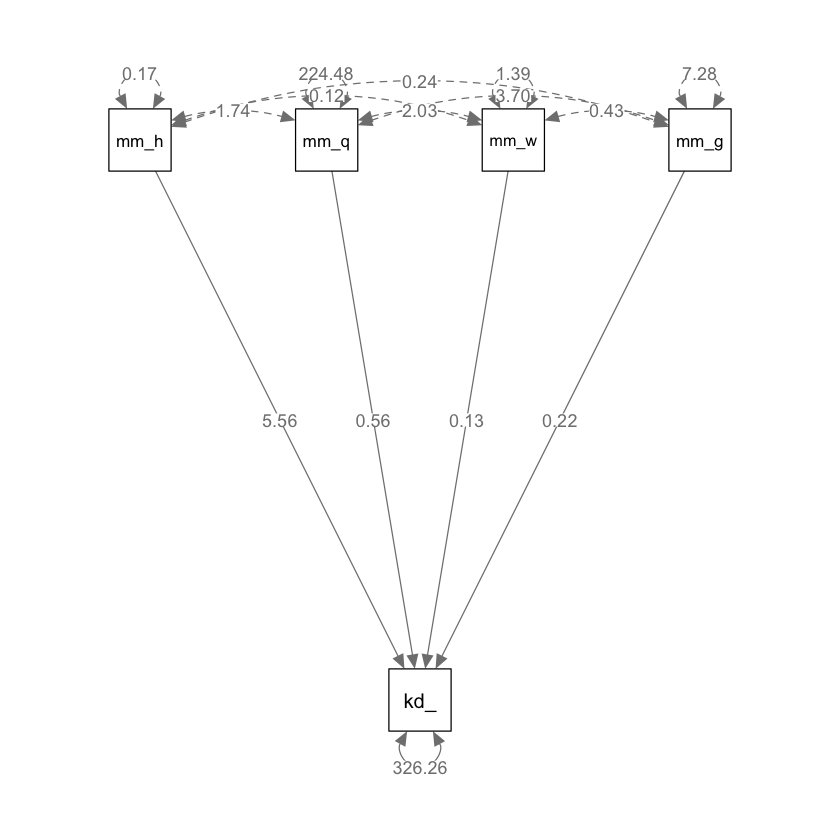

In [27]:
semPaths(
  fit, "est",
  posCol = c("black"),
  edge.label.cex = 0.9,
  sizeMan = 7, 
  what = "path"
)

Come indicato nel diagramma, l'effetto diretto di `mom_iq` su `kid_score` è identico al corrispondente coefficiente parziale di regressione.  

Il problema di capire se sia appropriato utilizzare un modello di regressione per descrivere le relazioni causali tra le variabili è affrontato nel prossimo paragrafo in riferimento all'errore di specificazione.

### Errore di specificazione

Spiritosamente chiamato "heartbreak of L.O.V.E." [Left-Out Variable Error; @mauro1990understanding], l'errore di specificazione è una caratteristica fondamentale dei modelli di regressione che deve sempre essere tenuta a mente quando interpretiamo i risultati di questa tecnica di analisi statistica. 

L'errore di specificazione si verifica quando escludiamo dal modello di regressione una variabile che ha due caratteristiche:

- è associata con altre variabili inserite nel modello,
- ha un effetto diretto sulla $y$.

Come conseguenza dell'errore di specificazione, l'intensità e il segno dei coefficienti parziali di regressione risultano sistematicamente distorti.

Consideriamo un esempio con dati simulati nei quali immaginiamo che la prestazione sia positivamente associata alla motivazione e negativamente associata all'ansia. Immaginiamo inoltre che vi sia una correlazione positiva tra ansia a motivazione. Ci chiediamo cosa succede al coefficiente parziale della variabile "motivazione" se la variabile "ansia" viene esclusa dal modello di regressione.

In [28]:
set.seed(123)
n <- 400
anxiety <- rnorm(n, 10, 1.5)
motivation <- 4.0 * anxiety + rnorm(n, 0, 3.5)
cor(anxiety, motivation)

[1] 0.8617706

Creo la variabile `performance` come una combinazione lineare di motivazione e ansia nella quale la motivazione ha un effetto piccolo, ma positivo, sulla prestazione, e l'ansia ha un grande effetto negativo sulla prestazione:

In [29]:
performance <-  0.5 * motivation - 5.0 * anxiety + rnorm(n, 0, 3)

Salvo i dati in un DataFrame:

In [30]:
sim_dat2 <- tibble(performance, motivation, anxiety)

Eseguo l'analisi di regressione specificando in maniera corretta il modello, ovvero usando come predittori sia l'ansia che la depressione:

In [31]:
fm1 <- lm(performance ~ motivation + anxiety, sim_dat2)

Le stime dei coefficienti parziali di regressione recuperano correttamente l'intensità e il segno dei coefficienti utilizzati nel modello generatore dei dati:

In [32]:
coef(fm1)

(Intercept)  motivation     anxiety 
  1.3711965   0.4953886  -5.1052176

Eseguo ora l'analisi di regressione ignorando il predittore `anxiety` che ha le due caratteristiche di essere associato a `motivation` e di avere un effetto diretto sulla prestazione:

In [33]:
fm2 <- lm(performance ~ motivation, sim_dat2)
summary(fm2)


Call:
lm(formula = performance ~ motivation, data = sim_dat2)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.501  -3.409   0.005   3.311  12.616 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -12.39720    1.44591  -8.574 2.24e-16 ***
motivation   -0.43717    0.03553 -12.305  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.866 on 398 degrees of freedom
Multiple R-squared:  0.2756,	Adjusted R-squared:  0.2738 
F-statistic: 151.4 on 1 and 398 DF,  p-value: < 2.2e-16


Si noti che, al di là della "significatività statistica" (si vedano le considerazioni fornite nel paragrafo sulla stepwise regression), il risultato prodotto dal modello di regressione è totalmente sbagliato: come conseguenza dell'errore di specificazione, il segno del coefficiente parziale di regressione della variabile "motivazione" è negativo, anche se nel modello generatore dei dati tale coefficiente aveva il segno opposto. 

Quindi, se interpretiamo il coefficiente parziale ottenuto in termini casuali, siamo portati a concludere che la motivazione fa diminuire la prestazione. Ma in realtà è vero l'opposto.

È facile vedere perché si verifica l'errore di specificazione. Supponiamo che il vero modello sia

$$
y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \varepsilon
$$

il quale verrebbe stimato da

$$
y = a + b_1 X_1 + b_2 X_2 + e.
$$

Supponiamo però che il ricercatore creda invece che

$$
y = \alpha^\prime + \beta_1^\prime X_1 + \varepsilon^\prime
$$

e quindi stimi

$$
y = a^\prime + b_1^\prime X_1 + e^\prime
$$

omettendo $X_2$ dal modello. 

Per capire che relazione intercorre tra $b_1^\prime$ e $b_1$, iniziamo a scrivere la formula per $b_1^\prime$:

$$
\begin{equation}
b_1^\prime = \frac{Cov(X_1, Y)}{Var(X_1)}.
\end{equation}
$$

Sviluppando, otteniamo

$$
\begin{equation}
\begin{aligned}
b_1^\prime &= \frac{Cov(X_1, a + b_1 X_1 + b_2 X_2 + e)}{Var(X_1)}\notag\\
&= \frac{Cov(X_1, a)+b_1 Cov(X_1, X_1) + b_2 Cov(X_1, X_2) + Cov(X_1, e)}{Var(X_1)}\notag\\
&= \frac{0 + b_1 Var(X_1) + b_2 Cov(X_1, X_2) + 0}{Var(X_1)}\notag\\
&= b_1 + b_2 \frac{Cov(X_1, X_2)}{Var(X_1)}.
\end{aligned}
\end{equation}
$$

Quindi, se erroneamente omettiamo $X_2$ dal modello, abbiamo che

$$
\begin{equation}
\mathbb{E}(b_1^\prime) = \beta_1 + \beta_2 \frac{\sigma_{12}}{\sigma_1^2}.
(\#eq:specific-err)
\end{equation}
$$

Verifichiamo tale conclusione per i dati dell'esempio che stiamo discutendo. Nel caso presente, $X_1$ è `motivation` e $X_2$ è `anxiety`. Applicando la \@ref(eq:specific-err) otteniamo lo stesso valore per il coefficiente di regressione associato a `motivation` che era stato ottenuto adattando ai dati il modello `performance ~ motivation`:

In [34]:
fm1$coef[2] +  fm1$coef[3] * 
  cov(sim_dat2$motivation, sim_dat2$anxiety) / 
  var(sim_dat2$motivation)

motivation 
-0.4371675

Possiamo dunque concludere che $b_1^\prime$ è uno stimatore distorto di $\beta_1$. Si noti che questa distorsione non scompare all'aumentare della numerosità campionaria, il che (in termini statistici) significa che un tale stimatore è _inconsistente_. Quello che succede in pratica è che alla variabile $X_1$ vengono attribuiti gli effetti delle variabili che sono state omesse dal modello. Si noti che una tale distorsione sistematica di $b_1^\prime$ può essere evitata solo se si verificano due condizioni:

- $\beta_2 = 0$. Questo è ovvio, dato che, se $\beta_2 = 0$, ciò significa che il modello non è specificato in modo errato, cioè $X_2$ non appartiene al modello perché non ha un effetto diretto sulla $Y$.
-  $\sigma_{12} = 0$. Cioè, se $X_1$ e $X_2$ sono incorrelate, allora l'omissione di una delle due variabili non comporta stime distorte dell'effetto dell'altra.

### Soppressione

Le conseguenze dell'errore di specificazione sono chiamate "soppressione" (_suppression_). In generale, si ha soppressione quando (1) il valore assoluto del peso beta di un predittore è maggiore di quello della sua correlazione bivariata con il criterio o (2) i due hanno segni opposti. 

- L'esempio descritto sopra è un caso di _soppressione negativa_, dove il predittore ha correlazioni bivariate positive con il criterio, ma si riceve un peso beta negativo nell'analisi di regressione multipla. 
- Un secondo tipo di soppressione è la _soppressione classica_, in cui un predittore non è correlato al criterio ma riceve un peso beta diverso da zero. 
- C'è anche la _soppressione reciproca_ che può verificarsi quando due variabili sono correlate positivamente con il criterio ma negativamente tra loro.

### Stepwise regression 

Un'implicazione della soppressione è che i predittori non dovrebbero essere selezionati in base ai valori delle correlazioni bivariate con il criterio. Queste associazioni, dette di ordine zero, non controllano gli effetti degli altri predittori, quindi i loro valori possono essere fuorvianti rispetto ai coefficienti di regressione parziale per le stesse variabili. Per lo stesso motivo, il fatto che le correlazioni bivariate con il criterio siano statisticamente significative o meno è irrilevante per quanto riguarda la selezione dei predittori. Sebbene le procedure informatiche di regressione  rendano facile i processi di selezione dei predittori in base a tali criteri, tali procedure sono da evitare. Il rischio è che anche piccole, ma non rilevate, non-linearità o effetti indiretti tra i predittori possano seriamente distocere i coefficienti di regressione parziale. È meglio selezionare giudiziosamente il minor numero di predittori sulla base di ragioni teoriche o dei risultati di ricerche precedenti. In altri termini, le procedure di stepwise regression non dovrebbero mai essere usate.

Una volta che sono stati selezionati, i predittori possono essere inseriti nell'equazione di regressione in due modi diversi: 

- tutti i predittori possono essere inseriti nel modello contemporaneamente;
- i predittori possono essere inseriti nel modello sequenzialmente, mediante una serie di passaggi. 

L'ordine di ingresso può essere determinato in base a standard: teorici (razionali) o empirici (statistici). Lo standard razionale corrisponde alla *regressione gerarchica*, in cui si comunica al computer un ordine fisso per inserire i predittori. Ad esempio, a volte le variabili demografiche vengono inserite nel primo passaggio, quindi nel secondo passaggio viene inserita una variabile psicologica di interesse. Questo ordine non solo controlla le variabili demografiche ma permette anche di valutare il potere predittivo della variabile psicologica, al di là di quello delle semplici variabili demografiche. Quest'ultimo può essere stimato come l'aumento della correlazione multipla al quadrato, o $\Delta R^2$, da quella della fase 1 con solo predittori demografici a quella della fase 2 con tutti i predittori nell'equazione di regressione.

Un esempio di standard statistico è la regressione _stepwise_, in cui il computer seleziona l'inserimento dei predittori in base esclusivamente alla significatività statistica; cioè, viene chiesto: quale predittore, se inserito nell'equazione, avrebbe il valore_$p$ più piccolo per il test del suo coefficiente di regressione parziale? Dopo la selezione, i predittori in una fase successiva possono essere rimossi dall'equazione di regressione in base ai loro valori-$p$ (ad esempio, se $p \geq$ .05). Il processo stepwise si interrompe quando, aggiungendo più predittori, $\Delta R^2$ non migliora. Varianti della regressione stepwise includono _forward inclusion_, in cui i predittori selezionati non vengono successivamente rimossi dal modello, e _backward elimination_, che inizia con tutti i predittori nel modello per poi rimuoverne alcuni in passi successivi. Per le ragioni descritte nel paragrafo sull'errore di specificazione, i metodi basati sulle procedure di stepwise regression non dovrebbero mai essere usati. Infatti, i problemi relativi a tale procedura sono così gravi che varie riviste non accettano studi che fanno uso di una tale tecnica statistica. I risultati ottenuti con tali metodi, infatti, sono quasi certamente non replicabili in campioni diversi.

Una considerazione finale riguarda l'idea di rimuovere i predittori "non significativi" dal modello di regressione. Questa è una cattiva idea. Il ricercatore non deve sentirsi in dovere di trascurare quei predittore che non risultano "statisticamente significativi". In campioni piccoli, la potenza dei test di significatività è  bassa e la rimozione di un predittore non significativo può alterare sostanzialmente la soluzione. Se c'è una buona ragione per includere un predittore, allora è meglio lasciarlo nel modello, fino a prova contraria. In termini generali, qualsiasi considerazione basata sulla "significatività statistia" è fuorviante.

## Proprietà degli stimatori dei minimi quadrati

Consideriamo il problema dell'inferenza statistica nel caso più semplice, quello della regressione bivariata. Il caso generale della regressione multipla segue lo stesso approccio, anche se le formule sono più complesse in quanto vengono formulate nei termini dell'albebra matriciale.

Per il caso bivariato, si può dire che il coefficiente dei minimi quadrati $b$ è una combinazione lineare delle osservazioni $y_i$. Tale proprietà è importante perché consente di derivare la distribuzione di $b$ dalla distribuzione delle $y_i$. 
Può essere dimostrato che la formula per il calcolo di $b$ si può scrivere nel modo seguente:

$$
\begin{align}
b &= \sum_i \left[\frac{x_i-\bar{x}}{\sum_j(x_j-\bar{x})^2}\right]y_i = \textstyle\sum m_i y_i,
\end{align}
$$

dove $m_i \triangleq (x_i-\bar{x}) / \sum (x_j-\bar{x})^2$ è il peso associato a ciascun valore $y_i$. Dato che i valori $x_i$ sono fissi e $m_i$ dipende solo da $x_i$, anche i pesi $m_i$ sono fissi.  

Il valore atteso di $b$ è uguale a 

$$
\begin{align}
E(b) &= \textstyle\sum m_i E(y_i)\notag\\ 
&= \textstyle\sum m_i (\alpha + \beta x_i)\notag\\ 
&= \textstyle\alpha\sum m_i + \beta \sum m_i x_i\notag\\
&= \frac{\alpha \sum(x_i-\bar{x})}{\sum(x_i-\bar{x})^2} + \beta \frac{\sum(x_i-\bar{x})x_i}{\sum(x_i-\bar{x})^2}\notag\\
&= 0 + \beta \frac{\sum x_i^2 -\bar{x}\sum x_i}{\sum(x_i-\bar{x})^2}\notag\\ 
&= \beta \frac{\sum x_i^2 - n\bar{x}^2}{\sum(x_i-\bar{x})^2}\notag\\ 
&= \beta.
\end{align}
$$

Il coefficiente dei minimi quadrati $b$ è dunque uno stimatore corretto di $\beta$. In maniera equivalente si può dimostrare che $E(a) = \alpha$.

Sotto le ipotesi di omoschedasticità $\big[ var(y_i) = var(\varepsilon_i)=\sigma^2_{\varepsilon}\big]$ e indipendenza, la varianza di $b$ è 

$$
\begin{align}
var(b) &= \textstyle var\big(\sum m_i y_i\big)\notag\\
&= \textstyle\mathop{\sum m_i^2} var(y_i)\notag\\ 
&= \textstyle\mathop{\sum m_i^2} \sigma^2_{\varepsilon}\notag\\
&= \frac{\mathop{\sigma^2_{\varepsilon}} \textstyle\sum(x_i-\bar{x})^2}{\big[\textstyle\sum(x_i-\bar{x})^2\big]^2}\notag\\
&= \frac{\sigma^2_{\varepsilon}}{\sum(x_i-\bar{x})^2}.
\end{align}
$$

In maniera simile si dimostra che la varianza di $a$ è 

$$
var(a)= \frac{\sigma^2_{\varepsilon} \textstyle\sum x_i^2}{n \textstyle\sum (x_i-\bar{x})^2}.
$$

Dato che sia $a$ che $b$ sono funzioni lineari di $y_i$, se i valori $y_i$ seguono la distribuzione gaussiana, allora anche  $a$ e $b$ saranno distribuiti secondo una distribuzione normale. In conclusione,

$$
\begin{align}
b &\sim \mathcal{N}\bigg(\beta,  \frac{\sigma^2_{\varepsilon}}{\sum(x_i-\bar{x})^2}\bigg),\\
a &\sim \mathcal{N}\bigg(\alpha, \frac{\sigma^2_{\varepsilon}\textstyle\sum x_i^2}{n \textstyle\sum (x_i-\bar{x})^2} \bigg).
\end{align}
$$

### Ipotesi statistiche e statistica test

Una volta definite le proprietà delle distribuzioni degli stimatori dei minimi quadrati è possibile procedere con l'inferenza sui parametri del modello di regressione.
L'inferenza statistica si articola nella formulazione degli intervalli di confidenza per i parametri di interesse e nei test di significatività statistica.

Un'ipotesi che viene frequentemente sottoposta a verifica è quella di significatività, cioè l'ipotesi che alla variabile esplicativa sia associato un coefficiente nullo.
In tal caso, l'ipotesi nulla è

$$H_0:\beta=0$$
e l'ipotesi alternativa è

  $$H_1:\beta \neq 0.$$
  
Sotto l'ipotesi nulla $H_0: \beta = 0$ la statistica

$$
 t_{\hat{\beta}} = \frac{\hat{\beta}}{s_{\hat{\beta}}}
$$

si distribuisce come una variabile aleatoria $t$ di Student con $n-2$ gradi di libert{\`a}.

Di fronte al problema di decidere se il valore stimato $\hat{\beta}$ sia sufficientemente "distante" da zero, in modo da respingere l'ipotesi nulla che il vero valore $\beta$ sia nullo, non è sufficiente basarsi soltanto sul valore numerico assunto da $\hat{\beta}$, ma occorre tener conto della variabilità campionaria.
La statistica ottenuta dividendo $\hat{\beta}$ per la stima del suo errore standard, $s_{\hat{\beta}}$, ci permette di utilizzare la distribuzione $t$ di  Student come metrica per stabilire se la stima trovata si debba considerare "diversa" da quanto ipotizzato sotto $H_0$.

L'ipotesi nulla viene rifiutata quando il valore assoluto del rapporto è esterno alla regione di accettazione, i cui limiti sono definiti dai valori critici della distribuzione $t$ di Student con $n - 2$ gradi di libertà per il livello di significatività $\alpha$ prescelto.
Se l'ipotesi nulla viene rifiutata si dice che il coefficiente $\hat{\beta}$ è \enquote{statisticamente significativo} ammettendo così la possibilità di descrivere con un modello lineare la relazione esistente tra le  variabili $X$ e $Y$.
Quando non si può rifiutare l'ipotesi nulla nel modello di regressione, si conclude che il coefficiente angolare della retta non risulta significativamente diverso da zero, individuando  così nella popolazione una retta parallela all'asse delle 

### Riportare i risultati

È consuetudine riportare i risultati dell'analisi di regressione in modo che insieme alle stime dei coefficienti vengano riportati i rispettivi errori standard stimati. Il valore-$p$ esprime la probabilità di ottenere un valore del test uguale o superiore a quello ottenuto nel campione esaminato, utilizzando la distribuzione campionaria del test sotto l'ipotesi nulla. 
Se $t_{\hat{\beta}}$ è il valore osservato del rapporto $t$ per il coefficiente angolare della retta di regressione, allora il { $p$-valore} è dato da

$$
p = 2 \times Pr(t \geq |t_{\hat{\beta}}|),
$$

dove $t$ è il valore di una variabile aleatoria $t$ di Student con $(n-2)$ gradi di libertà.

#### Regola di decisione

Ogni volta che il $p$-valore del test è inferiore al livello di significatività che si è scelto per $H_0$, il test porta al rifiuto dell'ipotesi nulla.
Solitamente si sceglie un livello $\alpha$ pari a 0.05 o 0.01.

I test di significatività possono essere eseguiti con R, utilizzando la funzione \texttt{summary()} applicata all'oggetto creato dal \texttt{lm()}.

Il test statistico sul parametro $\beta$ del modello di regressione verifica l'ipotesi nulla di indipendenza, ovvero l'ipotesi che, nella popolazione, la pendenza della retta di regressione sia uguale a zero. Pi{\`u} informativo del test statistico $H_0: \beta=0$ è  l'intervallo di confidenza per il parametro $\beta$:

$$
\hat{\beta} \pm t_{\alpha/2} s_{\hat{\beta}}.
$$

### Considerazioni conclusive

Il modello di regressione lineare semplice è un metodo per studiare la relazione tra due variabili e per prevedere il valore della variabile dipendente in base alla variabile indipendente. Tuttavia, questo modello è limitato poiché si concentra solo sulla relazione tra una singola variabile indipendente e la variabile dipendente. Quando ci sono più variabili indipendenti, il modello di regressione diventa più complesso e richiede l'uso dell'algebra matriciale. Questo modello può includere variabili indipendenti sia quantitative che qualitative e può essere utilizzato anche per l'analisi della varianza. Il modello lineare è alla base dell'analisi fattoriale, una tecnica ampiamente utilizzata per la costruzione e la validazione dei test psicometrici.


